# <center> Center of mass with the shrinking sphere method

In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import os

import pynbody
from pynbody.analysis.halo import shrink_sphere_center

The data we will use are from a tree code simulation of a plummer sphere in equilibrium. <br> The plummer distribution was initialized, centered around (0,0,0), with 
    $$  \text{Number of particles} =  3\times10^4\;
        \text{Total mass}          =  1\;
        \text{Scale parameter}     =  10     $$
The parameters of the simulation were
    $$
    \text{tstop} = 3\cdot t_{dyn} \sim 851 \;
    \text{dtime} = 0.1\;
    \text{eps}   = 0.03\;
    \text{theta} = 0.1\;
    \text{dtout} = 5
    $$

In [18]:
# N = 10^4 :   plummer_equilibrium1.txt
# N = 3*10^4 : plummer_equilibrium.txt

In [ ]:
#Read the data
data = pd.read_csv("plummer_equilibrium.txt", names=list(range(7)), sep = ' ')

The average number of particles inside a spherical shell of radius $r_1$ and $r_2$ is
$$<particles> = \int_{r_1}^{r_2}4\pi r^2 \rho(r) dr$$
The density profile of a Plummer sphere is:
$$\rho(r)=\frac{3M_{tot}}{4\pi b^3}\frac{1}{(1+\frac{r^2}{b^2})^{5/2}}$$
So the integral becomes
$$<particles> = \int_{r_1}^{r_2} \frac{3M_{tot}}{b^3} r^2 (1+\frac{r^2}{b^2})^{-5/2} dr = \frac{3M_{tot}}{b^3} \frac{r^3}{3(1+\frac{r^2}{b^2})^{3/2}}$$ evaluated between $r_1$ and $r_2$.


In [2]:
from IPython.display import display, Math, Latex
display(Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx'))


<IPython.core.display.Math object>

In [20]:
M_tot = 1
b = 10
N = 3*10**4
m = [M_tot/N]

def integral (r, b, M):
    return (M*r**3)/(b**3*(1+r**2/b**2)**(3/2))

#r1 = 0
#r2 = b
particles =  (integral(b,b,M_tot) - integral(0,b,M_tot))/(M_tot/N)
print(particles)

10606.601717798212


Define the function that find the center of mass of a distribution of particles in a fixed position. <br> It computes iteratively the center of mass of a shrinking sphere, following the idea of section 2.5 of [Power et al. (2003)](https://articles.adsabs.harvard.edu/pdf/2003MNRAS.338...14P) <br> Note that the center of mass is calculated assuming all the particles have the same mass.

In [21]:
def shrinking_sphere (x, y, z, N, min_particles = None):
    
    #Compute the initial center of mass
    cm_x = np.sum(x)/N
    cm_y = np.sum(y)/N
    cm_z = np.sum(z)/N
    
    cm = [((cm_x)**2+(cm_y)**2+(cm_z)**2)**0.5]
    
    counts = [0]
    i = 0
    
    cmx = []
    cmy = []
    cmz = []
    
    #Radii respect to (0,0,0) reduced by 2.5 percent
    rmax = np.max((x**2  + y**2 + z**2)**0.5) * 0.975  
    
    while True:
        
        #Compute the distances from the new center of mass
        x_temp = x - cm_x
        y_temp = y - cm_y
        z_temp = z - cm_z
        r_temp = (x_temp**2+y_temp**2+z_temp**2)**0.5
        
        #Take only the distances below the previous sphere radius reduced by 2.5%
        mask   = r_temp < rmax

        #Compute the new center of mass
        cm_x_temp = np.sum(x[mask])/len(x[mask])
        cm_y_temp = np.sum(y[mask])/len(x[mask])
        cm_z_temp = np.sum(z[mask])/len(x[mask])
        
        #Check if the center of mass has converged
        if (len(x[mask])<min_particles):
            break
        
        #Otherwise reset the center of mass
        cm_x = cm_x_temp
        cm_y = cm_y_temp
        cm_z = cm_z_temp
        cmx.append(cm_x)
        cmy.append(cm_y)
        cmz.append(cm_z)
        
        #Update counts and save the cm of the current iteration
        i += 1
        counts.append(i)
        cm.append(((cm_x)**2+(cm_y)**2+(cm_z)**2)**0.5)
        
        #Set the new radius
        rmax = np.max(((x[mask]-cm_x)**2 + (y[mask]-cm_y)**2 + (z[mask]-cm_z)**2)**0.5) * 0.975
        
        #Print to see the number of particles in each iteration
        #print('i',i,'n',len(x[mask]))

    '''
    #Show the center of mass at each iteration
    plt.plot(counts,cm)
    plt.xlabel('Iteration')
    plt.ylabel('CM')
    plt.show()
    '''
    return cm_x, cm_y, cm_z, cmx, cmy, cmz

Define the function to get the number of particles and their positions from the data. <br> Then, for each timestep, compute the center of mass with the shrinking sphere method and re-write the positions in the reference frame of the center of mass.

In [22]:
def dati (data, shrinking = False, min_particles=None):
    
    x = []
    y = []
    z = []
    
    #Number of particles used in the simulation
    N = np.array(data.iloc[0].copy())
    N = int(N[~np.isnan(N)])
    
    #Define start and step to save the data
    start = N + 3
    step  = N * 3 + 3
    
    #Save the positions
    a = (np.array([data.iloc[i::step,:].copy() for i in range(start,start+N)]))
    
    for j in range(len(a)):
        temp = np.array([a[j][i][~np.isnan(a[j][i])] for i in range(len(a[j]))])
        x.append(temp[:,0])
        y.append(temp[:,1])
        z.append(temp[:,2])
     
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    
    #Compute the center of mass at each time
    cm_x = []
    cm_y = []
    cm_z = []
        
    for i in range (len(x[0])):
        if (shrinking == True):
            cm_x_, cm_y_, cm_z_, cmx, cmy, cmz = shrinking_sphere(x[:,i],y[:,i],z[:,i],N,min_particles)
            cm_x.append(cm_x_)
            cm_y.append(cm_y_)
            cm_z.append(cm_z_)
        else:
            cm_x.append(np.sum(x.T[i])/N)
            cm_y.append(np.sum(y.T[i])/N)
            cm_z.append(np.sum(z.T[i])/N)
    
    x = x - cm_x
    y = y - cm_y
    z = z - cm_z
    
    r = (x**2+y**2+z**2)**0.5
    
    t = (np.array(data.iloc[2::step,:].copy()))[:,2]
    
    return x,y,z,r,t,cm_x,cm_y,cm_z, N

Applying the shrinking sphere at the data of the Plummer sphere

In [26]:
x,y,z,r,time,cm_x,cm_y,cm_z, Num = dati(data, shrinking = True, min_particles=int(particles))

See how the center of mass varies in time.

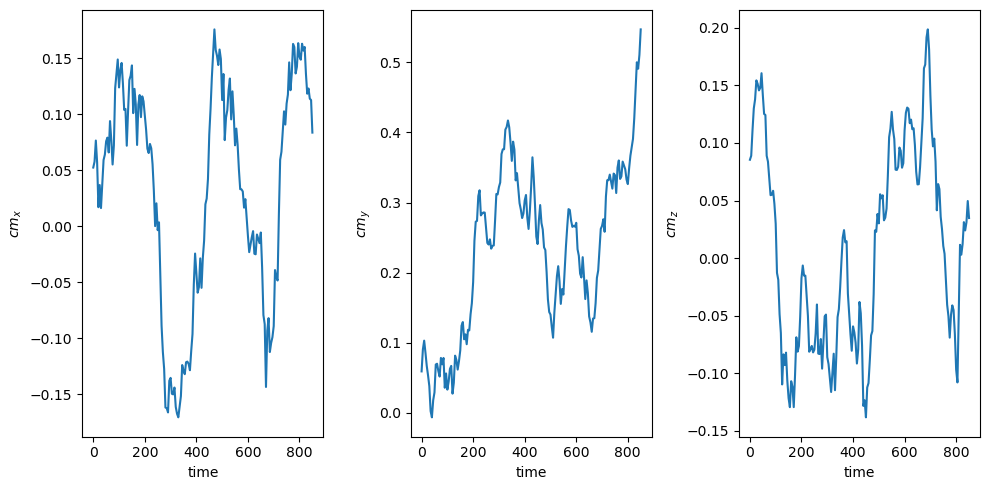

In [27]:
fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(10,5)) 

ax[0].plot(time,cm_x)
ax[0].set(xlabel = r'time', ylabel=r'$cm_x$') 

ax[1].plot(time,cm_y)
ax[1].set(xlabel = r'time', ylabel=r'$cm_y$')

ax[2].plot(time,cm_z)
ax[2].set(xlabel = r'time', ylabel=r'$cm_z$')
plt.show()

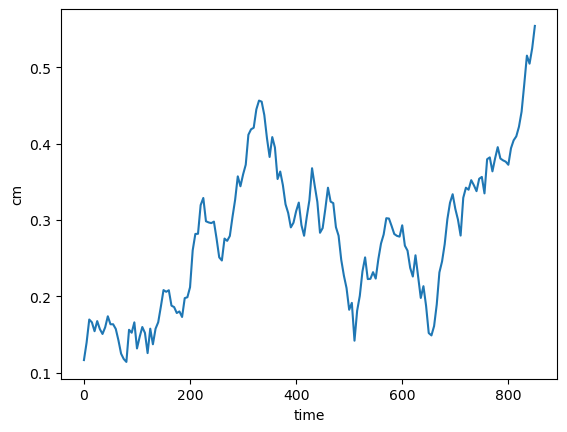

In [28]:
cm = [(np.array(cm_x)**2+np.array(cm_y)**2+np.array(cm_z)**2)**0.5]
plt.plot(time, cm[0])
plt.xlabel('time')
plt.ylabel('cm')
plt.show()

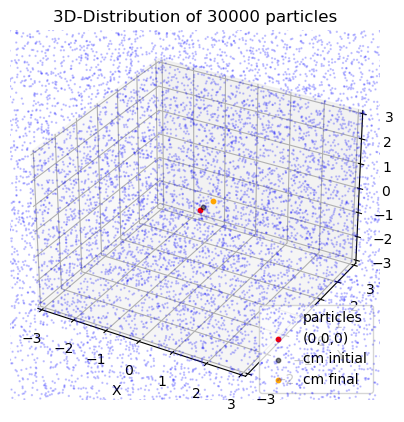

In [10]:
fig = plt.figure()
ax  = plt.axes(projection='3d')
ax.scatter3D(x[:,0],y[:,0],z[:,0],s=.5, color='blue',alpha=0.2, label='particles')
ax.scatter3D(0,0,0,s=10, color='red',alpha=1, label='(0,0,0)')
ax.scatter3D(cm_x[0],cm_y[0],cm_z[0],s=10, color='black',alpha=0.5, label='cm initial')
ax.scatter3D(cm_x[-1],cm_y[-1],cm_z[-1],s=10, color='orange',alpha=1, label='cm final')

#Change this value to set the view of the 3D space
view=3

ax.set(xlim=(-view,view), ylim = (-view,view), zlim = (-view,view))
ax.set(title = fr'3D-Distribution of {Num} particles', xlabel = r'X', ylabel = r'Y', zlabel = r'Z')
plt.legend()
plt.show()

## Using pynbody

Now, on the same data, we want to apply a pre-existent function to compute the center of mass following the same idea of the shrinking sphere. <br> To do this, we have to write our data in the SimSnap class format, representing a snapshot of a simulation.

Define the function to get the number of particles and their positions from the data.

In [11]:
def read_data (data):
    
    x = []
    y = []
    z = []
    positions = []
    
    #Number of particles used in the simulation
    N = np.array(data.iloc[0].copy())
    N = int(N[~np.isnan(N)])
        
    #Masses of the particles
    masses = np.array(data.iloc[3:N+3].copy())
    masses = masses[~np.isnan(masses)].transpose()

    start = N + 3
    step  = N * 3 + 3
    
    a = (np.array([data.iloc[i::step,:].copy() for i in range(start,start+N)]))
    for j in range(len(a)):
        temp = np.array([a[j][i][~np.isnan(a[j][i])] for i in range(len(a[j]))])
        x.append(temp[:,0])
        y.append(temp[:,1])
        z.append(temp[:,2])
        positions.append(np.hstack((temp[:,0],temp[:,1],temp[:,2])))

    r = np.array([(x[i]**2+y[i]**2+z[i]**2)**0.5 for i in range(N)])
    
    t = (np.array(data.iloc[2::step,:].copy()))[:,2]

    positions = np.array(positions)
    
    return masses, positions, t, N, np.max(r)

Apply the read_data function on our data

In [12]:
masses, positions, t, num, max_r = read_data(data)

Write the data in the SimSnap format. <br> In the list "snapshots" every entry is a SimSnap object representing a snapshot of the simulation.

In [13]:
snapshots = []
for i in range(1,len(t)+1):
    # Create a pynbody snapshot
    s = pynbody.new(n=num)
    s['pos']  = positions[:,3*(i-1):3*i]
    s['mass'] = masses
    s.properties['time'] = t[i-1]
    snapshots.append(s)

In [14]:
if (np.equal(snapshots[0]['pos'],positions[:,0:3]).all()) :
    print('evviva')

evviva


Compute the center of mass at each time using the shrinking sphere method [pynbody.analysis.halo.shrink_sphere_center](https://pynbody.github.io/pynbody/_modules/pynbody/analysis/halo.html#shrink_sphere_center). <br>
In order to make a comparison with the function in this notebook, we set its parameters <br><center> r= initial search radius <br> shrink_factor = the amount to shrink the search radius by on each iteration <br> min_particles = minimum number of particles within the search radius </center> equal to the ones used before.

In [15]:
centers = []
for s in snapshots:
    centers.append(pynbody.analysis.halo.shrink_sphere_center(s, r=max_r, shrink_factor=0.975, min_particles=int(particles)))

In [16]:
for s in snapshots:
    s['r'] = np.linalg.norm(s['pos'], axis=1)

Comparing the two methods

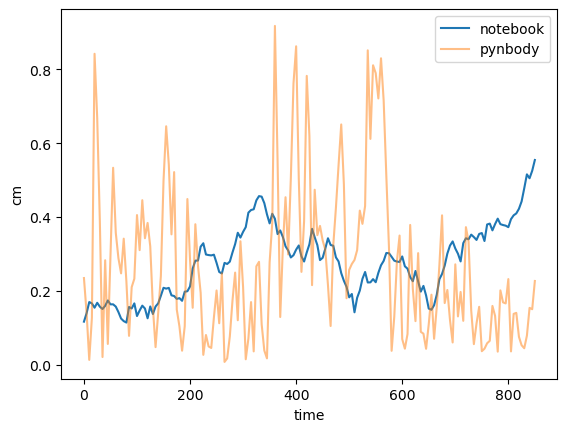

In [17]:
cm1 = (np.array(cm_x)**2+np.array(cm_y)**2+np.array(cm_z)**2)**0.5
cm2 = np.array([(centers[i][0]**2+centers[i][1]**2+centers[i][2]**2)**0.5 for i in range(len(centers))])
plt.plot(time, cm1, label='notebook')
plt.plot(time, cm2, alpha=0.5, label='pynbody')
plt.xlabel('time')
plt.ylabel('cm')
plt.legend()
plt.show()

The two methods gave different results. <br> Also the plummer sphere was set in equilibrium, so we don't expect significant changes of the center of mass of the system in time. <br> Instead with both methods it changes a lot even between close timesteps.

# Analysis of results

We analyzed the density profile for each timestep, startig by computing the volume of 1000 shells between zero and the maximum position of the particles. We, then, set a function in order to get the number of particles inside the shells at a fixed time.
We computed the density profile for each timestep, we sampled the mean density profile and its error by estimating the error on the number of particles obtained by the simulation.
In the end we quantified the propagation of the error to the density and we plotted the result.

In [18]:
#RUN THIS CELL ONLY TO USE THE PYNBODY RESULTS!
#r = []
#for s in snapshots:
#    r.append(s['r'])
#r = np.array(r)
#OTHERWISE SKIP

In [19]:
#Compute the volume of 1000 shells between 0 and the maximum position of the particles

#The problem was the binning all along!
#Do the binning in a log space and far away from the limits!
#raggi = np.linspace(0,np.max(r),1000)
raggi = np.geomspace(0.8,500,100)

delta_V = np.array([4*np.pi*raggi[i+1]**3/3 - 4*np.pi*raggi[i]**3/3 for i in range(len(raggi)-1)])

#Function to get the number of particles inside each shell at a fixed time
def number_particles(raggi, r, times):
    num_part = []
    for i in range(len(raggi)-1):
        left = raggi[i]
        right = raggi[i+1]
        provv = len([el for el in (r.T[int(times)]) if (left<el<right)])
        num_part.append(provv)
    return num_part
    
#Compute the density profile for each timestep
times = [0, int(len(r[0])/2), int(len(r[0])*3/4), len(r[0])-1]
density_ = np.array([(number_particles(raggi,r,times)/delta_V)*m[0] for times in times])

#Do the mean of the density profile in time
#density = np.mean(density_, axis = 0)

#Error on the number of particles by the simulation. Taken as the square root of the number of particles inside a shell.
error_N = np.array([np.sqrt(number_particles(raggi,r,times)) for times in times])
#Propagation of the error to the density
error_d = error_N * m[0] / delta_V


In order to compute the average number of particles inside each shell by using the analytical density distribution we applied the following equation:

$$<particles> = \int_{r_1}^{r_2}4\pi r^2 \rho(r) dr$$
Remind that the density profile of a Plummer sphere is:
$$\rho(r)=\frac{3M_{tot}}{4\pi b^3}\frac{1}{(1+\frac{r^2}{b^2})^{5/2}}$$
So the integral becomes
$$<particles> = \int_{r_1}^{r_2} \frac{3M_{tot}}{b^3} r^2 (1+\frac{r^2}{b^2})^{-5/2} dr = \frac{3M_{tot}}{b^3} \frac{r^3}{3(1+\frac{r^2}{b^2})^{3/2}}$$ evaluated between $r_1$ and $r_2$.
For each particle we took $1 \sigma$ as the error, since it is Poissonian we used the square root of the number of particles: $\sqrt{N}$. 
In the end we found the error propagation of the density

In [20]:
#Analitycal density profile
rho   = ((3*M_tot)/(4*np.pi*b**3))*(1/(1+(raggi**2/b**2))**(5/2))

#Function to compute the integral to get the number of particles
def integral (r,b):
    return r**3/(3*(1+r**2/b**2)**(3/2))

# p_integrale is the average number of particles in each shell predicted by the analytical solution
p_integrale = np.array([(integral(raggi[i+1],b) - integral(raggi[i],b))*(3*M_tot)/b**3 for i in range(len(raggi)-1)])

#We take 1 sigma as the error. Being Poissonian is the square root of the number of particles
error_p = np.sqrt(p_integrale)
#Error propagation on the density
error_d_t = error_p * m[0] / delta_V

In this graph we represented the analytic solution respect to the simulation in the logarothmic scale.

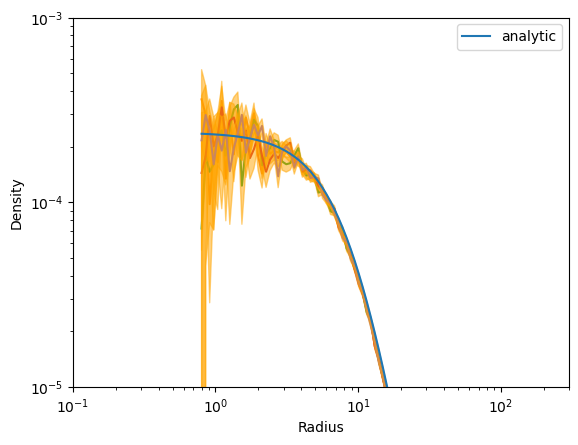

In [24]:
#Analytic solution
plt.plot(raggi[:-1],rho[:-1], label='analytic', zorder=10)
plt.fill_between(raggi[:-1], rho[:-1]-error_d_t, rho[:-1]+error_d_t, alpha=0.5, color='lightblue')

#Simulation
for density in density_:    
    plt.plot(raggi[:-1], density, zorder=1)
    plt.fill_between(raggi[:-1], density-error_d[0], density+error_d[0], alpha=0.5, color = 'orange')

#plt.axvline(x=b)

plt.xlim(0.1,300)
plt.ylim(1e-5,1e-3)

plt.xlabel('Radius')
plt.ylabel('Density')
plt.loglog()
plt.legend()
plt.show()

In this graph we show a zoom in of the analytic solution respect to the simulation without the logarithmic scale.

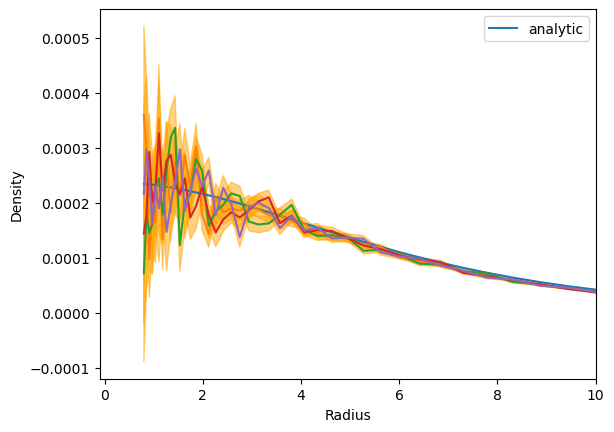

In [25]:
#Analytic solution
plt.plot(raggi[:-1],rho[:-1], label='analytic')
plt.fill_between(raggi[:-1], rho[:-1]-error_d_t, rho[:-1]+error_d_t, alpha=0.5, color='lightblue')

#Simulation
for density in density_:  
    plt.plot(raggi[:-1], density)
    plt.fill_between(raggi[:-1], density-error_d[0], density+error_d[0], alpha=0.5, color='orange')
    

plt.xlim(-0.1,10)
#plt.ylim(0,0.0000005)
    
plt.xlabel('Radius')
plt.ylabel('Density')
plt.legend()
plt.show()

Another check

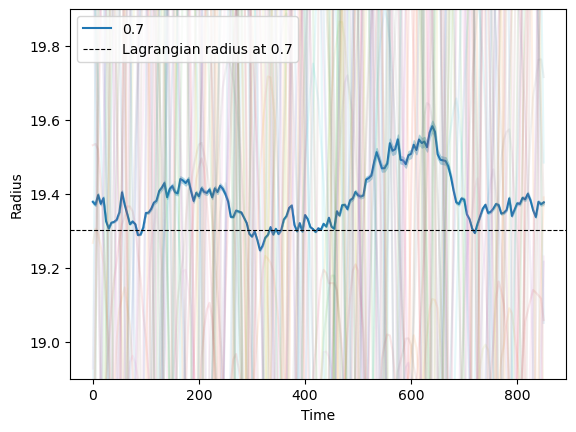

In [23]:
r_L = []
error = []
for i in range(len(time)):
    a    = np.sort(r[:,i])
    mask = a<np.quantile(a,0.7)
    lagr = (0.7**(-2/3)-1)**(-0.5)*b
    r_L.append(np.max(a[mask]))
    error.append(np.abs(lagr-np.max(a[mask]))/lagr)

#Plot the Lagrangian Radius with its error
r_L = np.array(r_L)
error = np.array(error)
plt.plot(time,r_L, label='0.7')
plt.fill_between(time, r_L-error, r_L+error, color='lightblue')


for i in range(0, N, 100):
    plt.plot(time,r[i], alpha=0.1)

    
plt.axhline(lagr, color = 'black', ls = '--', lw = .8, label='Lagrangian radius at 0.7')
plt.ylim(18.9,19.9)
plt.xlabel('Time')
plt.ylabel('Radius')
plt.legend()
plt.show()